# Introduction to PyCBC Inference 4: Advanced configuration settings
### Collin Capano

In this tutorial we delve into the more advanced settings for the configuration file. These can be used to fine-tune your run, and do more elaborate analyses.

We will use the provided example configuration file [bbh_example.ini](bbh_example.ini). This is the configuration file you would need to analyze signals like GW150914.

### Prerequisites

In [1]:
import os
from IPython.display import Image
from IPython.core.display import HTML

## Sampling transforms

The parameter space in which a prior is most easily defined is not necessarily the best space for sampling. The most common example of this are the component masses. We typically use a uniform prior on each component mass, which is easy to define and evaluate. However, component masses are difficult to measure (see Sebastian Khan's talk). In addition, if the prior is symmetric between the components (meaning you could swap the labels `1` and `2` and get the same result), then the posterior will be symmetric. This makes it difficult for the sampler to converge on the correct value.

Better parameters are the *chirp mass* $\mathcal{M}$ and *mass ratio* $q$. While the mass ratio is also difficult to measure (and in fact is less well-constrained than either component masses), chirp mass can be measured, especially for binary neutron star systems. It is therefore easier and faster for samplers to converge on chirp mass and mass ratio rather than `mass1` and `mass2`.

*Sampling transforms* provide the ability to replace one or more parameters in the `[variable_params]` section with other parameters that are (presumably) easier to sample. To use them, you must provide a `[sampling_params]` section. This lists the names of the parameters that will be used to sample in, in place of the variable params. In our example, we have:
```
[sampling_params]
; parameters on the left will be sampled in
; parametes on the right
mass1, mass2 : mchirp, q
```
In addition, we need to provide `[sampling_transforms]` sections that define what transform to use. Similar to the `[prior]` sections, the `[sampling_transforms]` must list the output parameter(s) in the header, as a `+` separated list. In our example we have:
```
[sampling_transforms-mchirp+q]
; inputs mass1, mass2
; outputs mchirp, q
name = mass1_mass2_to_mchirp_q
```
The `name` parameter defines which transform to use. Transforms are defined in PyCBC's [transforms module](https://pycbc.org/pycbc/latest/html/pycbc.html#module-pycbc.transforms); see the table [here](https://pycbc.org/pycbc/latest/html/inference.html#sampling-transforms) for a list of all of the currently available transforms.

In our case, we are using the [Mass1Mass2ToMchirpQ](https://pycbc.org/pycbc/latest/html/pycbc.html#pycbc.transforms.Mass1Mass2ToMchirpQ) transform. This knows to take the parameters named `mass1` and `mass2` and turn them into chirp mass and mass ratio, called `mchirp` and `q`, respectively.

#### Notes:
 * The dimension of the sampling parameter space must be the same as the prior space. This means that the number of parameters replaced must equal the number of parameters sampled.
 * An inverse transform and Jacobian are needed in order to transform between the sampling parameter space and the prior space. These are given by the transforms' `inverse_transform` attribute and `jacobian` method, respectively. Not all transforms in the `transforms` module have these defined. If you try to use a transform that does not have these properties, you'll get a `NotImplementedError`.
 * Currently, the CPNest sampler does not support sampling transforms.

## Waveform transforms

**The name and number of parameters set in the `[variable_params]` section can be anything.** If you like, you could name a parameter `claxmanfooblefar`. (There is one exception: names that start with `calib_` are assumed to be calibration parameters. See [here](https://pycbc.org/pycbc/latest/html/inference.html#calibration-parameters) for details.) However, certain parameter names must be provided to the waveform generator in order for it to work properly. For example, to set the masses of the binary, it must get parameters named `mass1` and `mass2`. 

The full list of recognized parameters by the CBC waveform generators can be found in the "Waveform transforms" section of the [PyCBC Inference documentation](https://pycbc.org/pycbc/latest/html/inference.html#waveform-transforms). Looking at the table there, we see that the spin parameters must be specified in cartesian coordinates, with names `spin1x`, `spin1y`, `spin1z`, `spin2x`, `spin2y`, `spin2z`. But looking at our list of `variable_params` we see that we've listed things called `spin1_a`, `spin1_polar`, `spin1_azimuthal` (same for `spin2`). Scrolling down to the prior section, we see that the priors for these parameters are:
```
[prior-spin1_a]
name = uniform
min-spin1_a = 0.0
max-spin1_a = 0.99

[prior-spin1_polar+spin1_azimuthal]
name = uniform_solidangle
polar-angle = spin1_polar
azimuthal-angle = spin1_azimuthal
```
(Likewise for `spin2`.) This defines a 3D prior that is uniform in magnitude and isotropic in direction. So, `spin1_a`, `spin1_polar` and `spin1_azimuthal` are spherical coordinates. But this doesn't mean anything to the waveform generator. It has no idea what something called `spin1_a` does, regardless of what its prior is.

To link our arbitrarily named `variable_params` to things that the waveform generator recognizes, we need to provide a `[waveform_transforms]` section. The syntax is the same as `[sampling_transforms]`:
 * The output of the transform needs to be provided in the section header. If it outputs multiple parameters, they should be `+` separated.
 * A `name` must be provided that gives the name of the transform to use.
 * Any transform in the [transforms module](https://pycbc.org/pycbc/latest/html/pycbc.html#module-pycbc.transforms) may be used.
 
In our example we have:
```
[waveform_transforms-spin1x+spin1y+spin1z]
name = spherical_spin_1_to_cartesian_spin_1
```
The `spherical_spin_1_to_cartesian_spin_1` transforms knows to look for `spin1_a`, `spin1_polar` and `spin1_azimuthal`, which it transforms to `spin1x`, `spin1y`, and `spin1z`. We have a similar transform for spin2.

*Note: In a future update, the separate `spherical_spin_(1/2)_to_cartesian_spin_(1/2)` transforms will be turned into a single `spherical_to_cartesian` transform in which the input and output variable names need to be provided explicitly.*

## Variable vs waveform vs sampling parameters

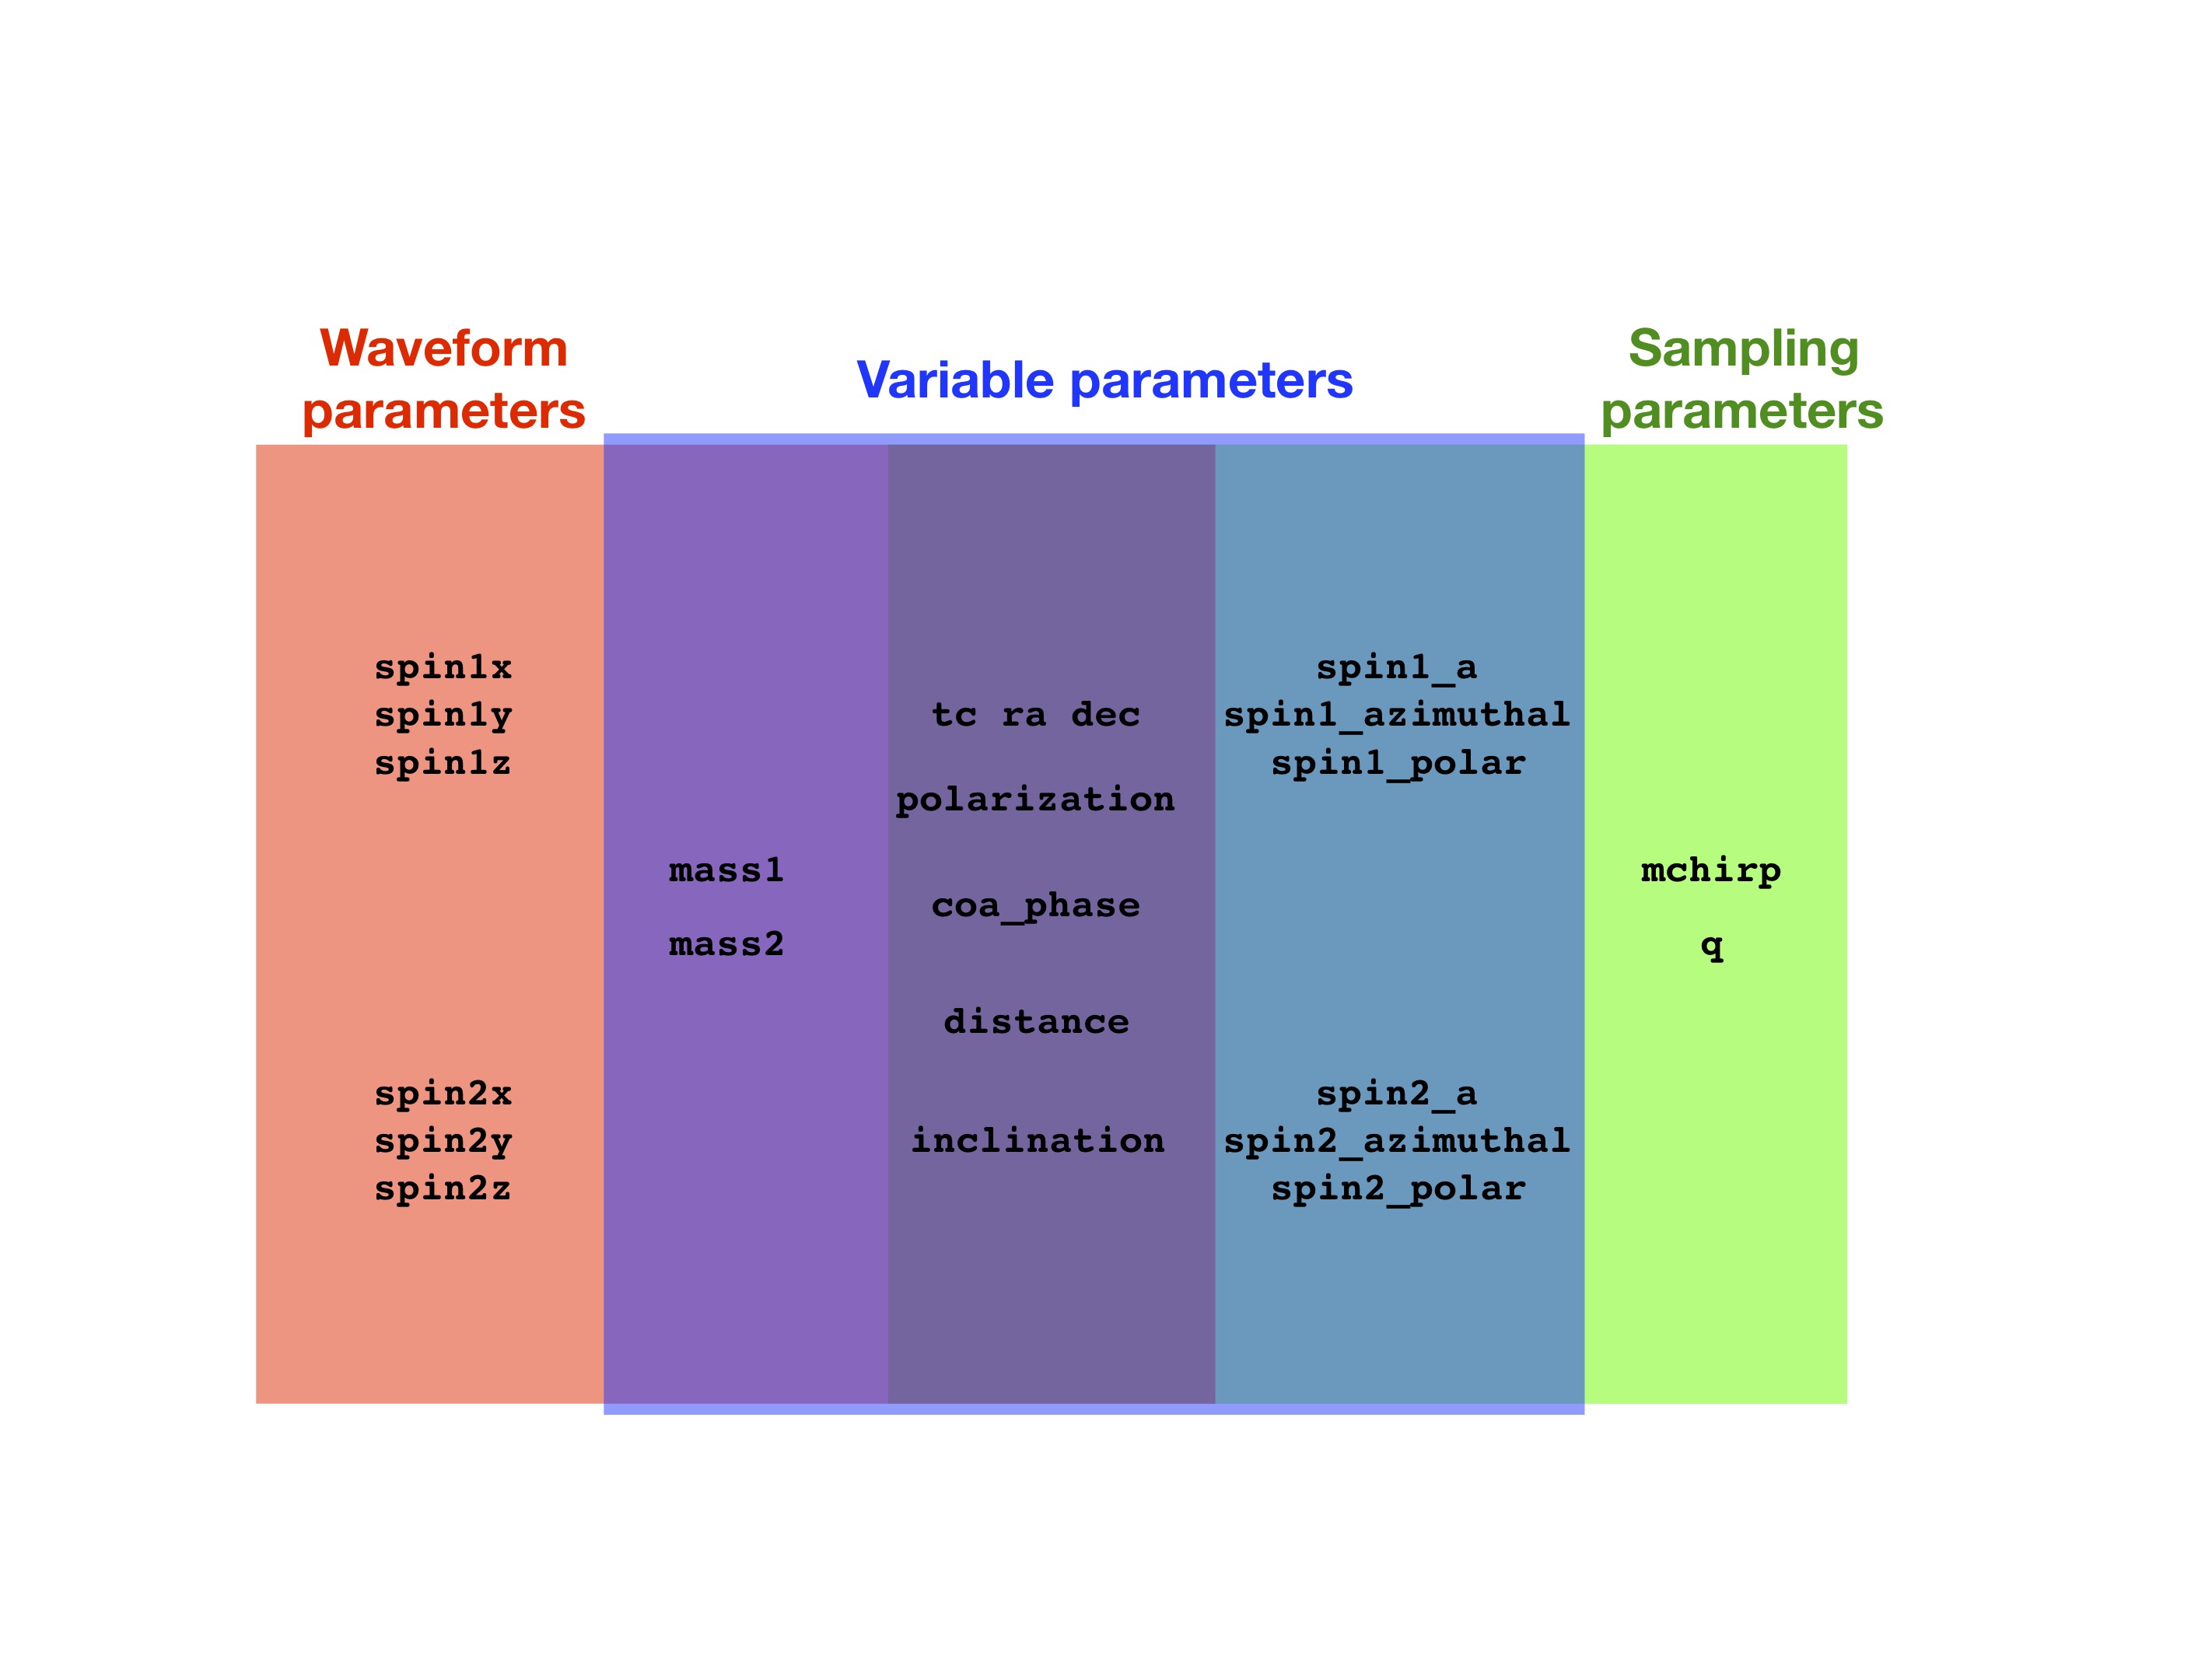

In [3]:
Image('paramsdiagram.png')

## Custom waveform transforms

Unlike sampling transforms, waveform transforms do not need a Jacobian nor an inverse specified. In addition, the number of waveform parameters need not be the same as the number of `variable_params`. This means that you can use the [CustomTransform](http://pycbc.org/pycbc/latest/html/pycbc.html#pycbc.transforms.CustomTransform) to create arbitrary transforms using any function in the [pycbc.conversions](http://pycbc.org/pycbc/latest/html/pycbc.html#module-pycbc.conversions), [pycbc.coordinates](http://pycbc.org/pycbc/latest/html/pycbc.html#module-pycbc.coordinates), or [pycbc.cosmology](http://pycbc.org/pycbc/latest/html/pycbc.html#module-pycbc.cosmology) modules, along with numpy math functions.

For example, the included [gw170817_example-common_eos.ini](gw170817_example-common_eos.ini) configuration file is similar to what was used in [De et al.](https://arxiv.org/abs/1804.08583) to analyze GW170817 (a binary neutron star) with a common equation of state. The common equation of state was enforced by having a single `lambdasym` parameter to describe the tidal deformability. The tidal deformation of each component `lambda1` and `lambda2` was related to `lambdasym` via:

\begin{align}
\Lambda_1 &= q^3 \Lambda_{\mathrm{sym}} \\
\Lambda_2 &= q^{-3} \Lambda_{\mathrm{sym}}
\end{align}

That is accomplished in the configuration file via:
```
[waveform_transforms-lambda1]
name = custom
inputs = mass1, mass2, lambdasym
lambda1 = lambdasym/((mass1/mass2)**3)

[waveform_transforms-lambda2]
name = custom
inputs = mass1, mass2, lambdasym
lambda2 = lambdasym/((mass2/mass1)**3)
```

## Challenge:

Modify [bbh_example.ini](bbh_example.ini) to create an analysis that uses a prior uniform in *source* masses. Hints:
 * The waveform generator needs the masses in the detector frame. In other words, you have to use the distance to redshift the mass parameters that are passed to the waveform generator.
 * You will need to use waveform transforms.
 * There is a `redshift` function available in the cosmology module that takes distance as an argument.
 * Keep in mind that the parameters passed to the waveform generator must be called `mass1` and `mass2`. What will you call the mass parameters in the `variable_params` section and prior?